In [1]:
# Random Imports
import os
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

# Regular schema dictates that we put DATAPATH
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))
os.environ['WANDB_NOTEBOOK_NAME'] = 'train.ipynb'

%load_ext yamlmagic
%load_ext autoreload
%autoreload 2

## Initialize the runner used to run jobs.

In [2]:
# Submit cell
from ese.experiment.experiment.ese_exp import CalibrationExperiment 
from ionpy.slite import SliteRunner

# List the available gpus for a machine
available_gpus = ['0', '1', '2', '3']

# Configure Slite Object
srunner = SliteRunner(
    project='ESE',
    exp_name='debug',
    task_type=CalibrationExperiment, 
    available_gpus=available_gpus
    )

Initalized SliteRunner


## Define said jobs

In [3]:
from ionpy.util.config import check_missing

def validate_cfg(cfg):
    # It's usually a good idea to do a sanity check of
    # inter-related settings or force them manually
    check_missing(cfg)        
    return cfg

In [4]:
%%yaml default_cfg 

experiment:
  seed: 42
    
dataloader:
  batch_size: 1 
  num_workers: 1 
  pin_memory: False 

optim: 
  _class: torch.optim.Adam
  lr: 3.0e-4
  weight_decay: 0.0 
  
train:
  epochs: 500 
  eval_freq: 50
  
log:
  checkpoint_freq: 50 
  root: '?'
  metrics:
    dice_score:
      _fn: ionpy.metrics.dice_score
      from_logits: True
      batch_reduction: 'mean' 

loss_func: 
  _class: ionpy.loss.SoftDiceLoss
  from_logits: True
  batch_reduction: 'mean' 

<IPython.core.display.Javascript object>

In [5]:
%%yaml model_cfg  

model:
  _class: ese.experiment.models.UNet
  in_channels: 3
  out_channels: 80 
  filters: '?'
  convs_per_block: 3

<IPython.core.display.Javascript object>

In [6]:
%%yaml dataset_cfg 

# data:
#   _class: ese.experiment.datasets.WMH
#   annotator: observer_o12
#   axis: 0
#   preload: False 
#   num_slices: 1
#   task: Amsterdam 
#   version: 0.2

data:
  _class: ese.experiment.datasets.COCO 

<IPython.core.display.Javascript object>

In [7]:
%%yaml lite_aug_cfg

- RandomAffine:
    p: 0.5
    degrees: [0, 360]
    translate: [0, 0.2]
    scale: [0.8, 1.1]
- RandomVariableElasticTransform:
    p: 0.75
    alpha: [1, 2] 
    sigma: [7, 9]
- RandomHorizontalFlip:
    p: 0.5
- RandomVerticalFlip:
    p: 0.5

<IPython.core.display.Javascript object>

In [8]:
%%yaml callbacks_cfg

callbacks:
  step:
    - ese.experiment.callbacks.ShowPredictions:
        label_cmap: tab10 
  epoch:
    - ese.experiment.callbacks.WandbLogger
    - ionpy.callbacks.ETA
    - ionpy.callbacks.JobProgress
    - ionpy.callbacks.TerminateOnNaN
    - ionpy.callbacks.PrintLogged
    - ionpy.callbacks.ModelCheckpoint:
        monitor: dice_score
        phase: val

<IPython.core.display.Javascript object>

In [9]:
from ionpy.util import Config
import pickle
import copy

# Assemble base config
base_cfg = Config(default_cfg).update(model_cfg).update(dataset_cfg).update(callbacks_cfg)

# Save the base cfg and the lite aug cfg
with open('/storage/vbutoi/projects/ESE/configs/base.pkl', 'wb') as base_config_file:
    pickle.dump(base_cfg, base_config_file)
    
with open('/storage/vbutoi/projects/ESE/configs/lite_aug.pkl', 'wb') as aug_config_file:
    pickle.dump(sum([copy.deepcopy(lite_aug_cfg)], start=[]), aug_config_file)

## Debug Station

In [10]:
# Need to define the experiment name
exp_name = 'debug'

# Create the ablation options
option_set = [
    {
        'log.root': ['/storage/vbutoi/scratch/ESE/debug'],
        'dataloader.batch_size': [1],
        'model.filters': [[128, 128, 128, 128, 128]],
    },
]

In [11]:
from ese.scripts.utils import get_option_product
import copy

# Get the configs
cfgs = get_option_product(exp_name, option_set, base_cfg)

# Add Augmentations
for cfg_idx in range(len(cfgs)):
    
    for add_aug in [False]:
        if add_aug:
            cfgs[cfg_idx] = cfgs[cfg_idx].set('augmentations', sum([copy.deepcopy(lite_aug_cfg)], start=[]))

loading annotations into memory...
Done (t=15.91s)
creating index...
index created!
loading annotations into memory...
Done (t=0.54s)
creating index...
index created!
loading annotations into memory...
Done (t=0.45s)
creating index...
index created!
Running CalibrationExperiment("/storage/vbutoi/scratch/ESE/debug/20230910_184257-Q44U-44da1ac06d982abafe9336c9238520ab")
---
callbacks:
  epoch:
  - ese.experiment.callbacks.WandbLogger
  - ionpy.callbacks.ETA
  - ionpy.callbacks.JobProgress
  - ionpy.callbacks.TerminateOnNaN
  - ionpy.callbacks.PrintLogged
  - ionpy.callbacks.ModelCheckpoint:
      monitor: dice_score
      phase: val
  step:
  - ese.experiment.callbacks.ShowPredictions:
      label_cmap: tab10
data:
  _class: ese.experiment.datasets.COCO
dataloader:
  batch_size: 1
  num_workers: 1
  pin_memory: false
experiment:
  seed: 42
log:
  checkpoint_freq: 50
  metrics:
    dice_score:
      _fn: ionpy.metrics.dice_score
      batch_reduction: mean
      from_logits: true
  root: 

wandb: Currently logged in as: vbutoi. Use `wandb login --relogin` to force relogin


Start epoch 0


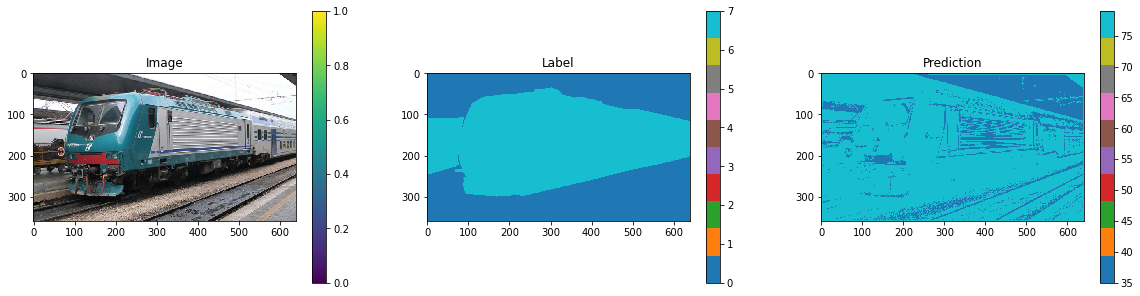

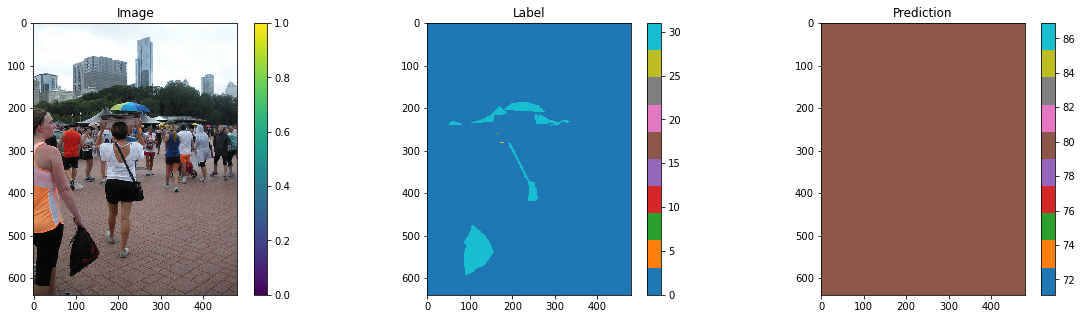

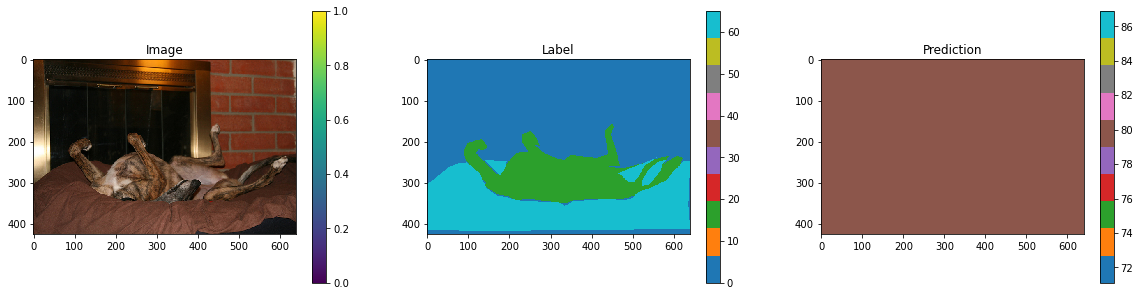

RuntimeError: cuDNN error: CUDNN_STATUS_INTERNAL_ERROR
You can try to repro this exception using the following code snippet. If that doesn't trigger the error, please include your original repro script when reporting this issue.

import torch
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.allow_tf32 = True
data = torch.randn([1, 128, 640, 425], dtype=torch.float, device='cuda', requires_grad=True)
net = torch.nn.Conv2d(128, 80, kernel_size=[1, 1], padding=[0, 0], stride=[1, 1], dilation=[1, 1], groups=1)
net = net.cuda().float()
out = net(data)
out.backward(torch.randn_like(out))
torch.cuda.synchronize()

ConvolutionParams 
    memory_format = Contiguous
    data_type = CUDNN_DATA_FLOAT
    padding = [0, 0, 0]
    stride = [1, 1, 0]
    dilation = [1, 1, 0]
    groups = 1
    deterministic = false
    allow_tf32 = true
input: TensorDescriptor 0x5615dc592c40
    type = CUDNN_DATA_FLOAT
    nbDims = 4
    dimA = 1, 128, 640, 425, 
    strideA = 34816000, 272000, 425, 1, 
output: TensorDescriptor 0x7f1f280c3ba0
    type = CUDNN_DATA_FLOAT
    nbDims = 4
    dimA = 1, 80, 640, 425, 
    strideA = 21760000, 272000, 425, 1, 
weight: FilterDescriptor 0x7f1f280b99a0
    type = CUDNN_DATA_FLOAT
    tensor_format = CUDNN_TENSOR_NCHW
    nbDims = 4
    dimA = 80, 128, 1, 1, 
Pointer addresses: 
    input: 0x7f1fda70e000
    output: 0x7f1fd540c000
    weight: 0x7f20bcfb6c00


In [12]:
srunner.run_exp(cfgs[0])